# Deep Learning with tSNE visualizations on MNIST Dataset

In this notebook, we will explore the t-distributed Stochastic Neighbor Embedding (tSNE) as a visualization tool using the MNIST dataset. tSNE is a powerful dimensionality reduction technique that focuses on local pairwise similarities between the input features. It has been shown to outperform other techniques, including PCA, ISOMAP, locally linear embedding, etc (see van der Maaten and Hinton, JMLR, 2008). The visualizations resulting from tSNE dimensionality reduction is ridiculously cool and has been insightful for understanding the structure of the data. It certainly warrants an exploration.

tSNE works by minimizing the Kullback-Leibler divergence between the high dimensional dataset $p_{i,j}$ and the distribution of the low dimensional data projection $q_{i,j}$. This cost allows tSNE to preserve local similarity structure of the high dimensional data on the lower dimensional projection. The student's t-distribution was an important addition as it has a heavy tail to improve how it handles dissimilar points (avoiding the crowding problem).

In this notebook, we will explore tSNE on the MNIST dataset with 3 different representations, directly on the raw pixels, via convolutional neural networks, and a convolutional autoencoder network.  Let's get started!


In [1]:
from __future__ import print_function
import os, sys, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

import numpy as np
np.random.seed(247)   # for reproducibility

# stochastic neighbor embedding (to install --> pip install tsne)
from tsne import bh_sne

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


#### Load the MNIST dataset 

Note, if you don't have the MNIST dataset, you can download it via:

!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

In [2]:
# load mnist data
fname = '/home/peter/Data/mnist/mnist.pkl.gz'
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = pickle.load(f)
f.close()
X_train, y_train = train_set
X_valid, y_valid = valid_set
X_test, y_test = test_set

num_labels = 10
num_train = len(y_train)
num_valid = len(y_valid)
num_test = len(y_test)


## tSNE on MNIST pixels

Let's first directly run tSNE with the Barnes-Hut approximation directly on the pixels of the images from the MNIST dataset.

In [ ]:
# perform t-SNE embedding
vis_data = bh_sne(X_train.astype(float))
vis_x = vis_pixel[:, 0]
vis_y = vis_pixel[:, 1]

tSNE is completely unsupervised. But it is more visually appealing as well as informative if we give the projection coordinates a color based on the labels.  

In [ ]:
# plot the result
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y, c=y_train[:len(X_train)+1], cmap=plt.cm.get_cmap("jet", num_labels),  edgecolor = 'none')
plt.axis('off')
plt.show()

This is a cool visualization of the data, but we don't know what the structure of the data look like within each class. Evidently, we can learn more about the structure of the data if we embed the acutal images onto each projection coordinate. 

In [ ]:
# setup a colormap
colormap = cm.gist_rainbow(np.linspace(0, 255, num_labels).astype(int))

# rescale embedding coordinates within [0, 1]
vis_pixel -= np.min(vis_pixel)
vis_pixel /= np.max(vis_pixel)

# create canvas to embed images
canvas_size = 5000
canvas = np.zeros((canvas_size, canvas_size, 3)).astype(np.uint8)

# set image_size, will downsample if smaller than 28
image_size = 28
scale = canvas_size-image_size

# embed images onto canvas
num_samples = 50000
for i in range(num_samples):
    pos = np.ceil(vis_pixel[i,:]*scale).astype(int)
    downsample_img =imresize(np.reshape(X_train[i], (28,28)),(image_size, image_size))
    for j in range(3):
        canvas[pos[0]:pos[0]+image_size,pos[1]:pos[1]+image_size,j] = downsample_img*colormap[y_train[i]][j]
            
    
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(15, 15, forward=True)
plt.imshow(np.invert(canvas), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

This is really cool. You can visualize the manifold within each class.  The ones lean one way on the left and lean to the other side on the right.  It shows you the range of representations that tSNE was able to group together.  Interestingly, classes that are similar, like 4 and 9 are close together, while 3 and 8 are also closer together, which makes sense.  

But can we do better if we use more informative features? Let's use deep convolutional neural networks to learn new features from the data and then use these as inputs to tSNE. Then we can do a side by side comparison whether deep learning representations are indeed more informative compared to raw pixel values. 

Let's setup a simple convolutional neural network with 3 convolutional layers followed by a dense layer.

In [94]:
# build model
input_var = T.tensor4('input')
target_var = T.ivector('target')

l_in = layers.InputLayer(shape=(None,1,28,28), input_var=input_var, name='input')

l_conv1 = layers.Conv2DLayer(l_in, num_filters=50, filter_size=(5,5), W=init.GlorotUniform(), 
                                   b=init.Constant(0.05), nonlinearity=None, pad='same')
#l_norm1 = layers.BatchNormLayer(l_conv1)
l_nonlin1 = layers.NonlinearityLayer(l_conv1, nonlinearity=nonlinearities.rectify)
l_pool1 = layers.MaxPool2DLayer(l_nonlin1, pool_size=(2,2))

l_conv2 = layers.Conv2DLayer(l_pool1, num_filters=35, filter_size=(3,3), W=init.GlorotUniform(), 
                                   b=init.Constant(0.05), nonlinearity=None, pad='same')
#l_norm2 = layers.BatchNormLayer(l_conv2)
l_nonlin2 = layers.NonlinearityLayer(l_conv2, nonlinearity=nonlinearities.rectify)
l_pool2 = layers.MaxPool2DLayer(l_nonlin2, pool_size=(2,2))

l_conv3 = layers.Conv2DLayer(l_pool2, num_filters=20, filter_size=(3,3), W=init.GlorotUniform(), 
                                   b=init.Constant(0.05), nonlinearity=None, pad='same')
#l_norm3 = layers.BatchNormLayer(l_conv3)
l_nonlin3 = layers.NonlinearityLayer(l_conv3, nonlinearity=nonlinearities.rectify)

l_dense4 = layers.DenseLayer(l_nonlin3,  num_units=200, W=init.GlorotUniform(), 
                             b=init.Constant(0.0), nonlinearity=None)
l_norm4 = layers.BatchNormLayer(l_dense4)
l_nonlin4 = layers.NonlinearityLayer(l_norm4, nonlinearity=nonlinearities.rectify)

l_out = layers.DenseLayer(l_nonlin4,  num_units=10, W=init.GlorotUniform(), 
                             b=init.Constant(0.0), nonlinearity=nonlinearities.softmax)

# setup loss for training and validation
prediction = get_output(l_out)
train_loss = objectives.categorical_crossentropy(prediction, target_var)
train_loss = train_loss.mean()

valid_prediction = get_output(l_out, deterministic=True)
valid_loss = objectives.categorical_crossentropy(valid_prediction, target_var)
valid_loss = valid_loss.mean()

valid_acc = T.mean(T.eq(T.argmax(valid_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

# setup adam optimizer
params = get_all_params(l_out, trainable=True)
update_op = updates.adam(train_loss, params)

train_fn = theano.function([input_var, target_var], train_loss, updates=update_op, allow_input_downcast=True)
val_fn = theano.function([input_var, target_var], [valid_loss, valid_acc], allow_input_downcast=True)

Train the model with mini-batches

In [95]:
# reshape from (50000, 784) to 4D tensor (50000, 1, 28, 28)
X_train = np.reshape(X_train, (-1, 1, 28, 28))
X_valid = np.reshape(X_valid, (-1, 1, 28, 28))

# setup mini-batch generator
def batch_generator(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('float32')

batch_size = 512
num_train_batches = len(X_train) // batch_size
train_batches = batch_generator(X_train, y_train, batch_size)

num_valid_batches = len(X_valid) // batch_size
valid_batches = batch_generator(X_valid, y_valid, batch_size)

# train network (for short time -- MNIST is quick to train)
n_epochs = 12
for e in range(n_epochs):
    ave_loss = 0
    for index in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        train_loss = train_fn(X_batch, y_batch)
        ave_loss += train_loss
    print("train: %f" % float(ave_loss/num_train_batches))

    ave_loss = 0
    ave_acc = 0
    for index in range(num_valid_batches):
        X_batch, y_batch = next(valid_batches)
        valid_loss, valid_acc = val_fn(X_batch, y_batch)
        ave_loss += valid_loss
        ave_acc += valid_acc
    print("valid: %f" % float(ave_loss/num_valid_batches))
    print("accuracy: %f" % float(ave_acc/num_valid_batches))

train: 0.224782
valid: 0.085767
accuracy: 0.977076
train: 0.047998
valid: 0.058379
accuracy: 0.981805
train: 0.031174
valid: 0.046531
accuracy: 0.987767
train: 0.021126
valid: 0.088804
accuracy: 0.974301
train: 0.016282
valid: 0.042637
accuracy: 0.988178
train: 0.011889
valid: 0.031515
accuracy: 0.990954
train: 0.009965
valid: 0.035546
accuracy: 0.990543
train: 0.007502
valid: 0.038793
accuracy: 0.988384
train: 0.006665
valid: 0.039360
accuracy: 0.990543
train: 0.004310
valid: 0.026748
accuracy: 0.992290
train: 0.003857
valid: 0.042493
accuracy: 0.988076
train: 0.004093
valid: 0.034075
accuracy: 0.989823


Let's take a look at the weights of the first convolutional layer to see if it's learned diverse features


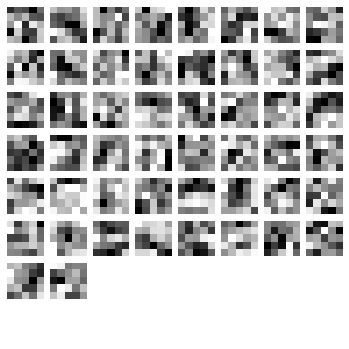

In [59]:
def plot_conv_weights(layer, figsize=(6, 6)):
    W =  np.squeeze(layer.W.get_value())
    shape = W.shape
    nrows = np.ceil(np.sqrt(shape[0])).astype(int)
    ncols = nrows

    figs, axes = plt.subplots(nrows, ncols, figsize=figsize,frameon=False)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    for i, ax in enumerate(axes.ravel()):
        if i >= shape[0]:
            break
        im = ax.imshow(W[i], cmap='gray', interpolation='nearest')
    return figs, axes

figs, axes = plot_conv_weights(l_conv1)

The filters look fine.  I don't see too many redundant features, so let's move on. 

In [60]:
shape = get_output_shape(l_nonlin3)
encode = theano.function([input_var], layers.get_output(l_nonlin3), allow_input_downcast=True)

batch_size = 512
num_batches = len(X_train) // batch_size
val = np.zeros(shape[1]*shape[2]*shape[3])
label = np.zeros(1)
index = np.zeros(1)
for i in range(num_batches):
    index = np.vstack([index, np.reshape(np.arange(i*batch_size,(i+1)*batch_size), (batch_size,-1) )])
    code = encode(X_train[i*batch_size:(i+1)*batch_size])
    val = np.vstack([val, np.reshape(code, (batch_size,-1))])
    label = np.vstack([label, np.reshape(y_train[i*batch_size:(i+1)*batch_size], (batch_size,-1))])
label = np.squeeze(label).astype(int)
index = np.squeeze(index).astype(int)
X2 = np.reshape(val, (val.shape[0],-1))
X2.shape

(49665, 980)

Now perform tSNE using the Barnes-Hut approximation (takes about 10 minutes).

In [61]:
# perform t-SNE embedding
vis_cnn = bh_sne(X2.astype(float))
vis_x = vis_cnn[:, 0]
vis_y = vis_cnn[:, 1]

Let's first visualize with datapoints on the 2D projection surface with colors given by their respective labels

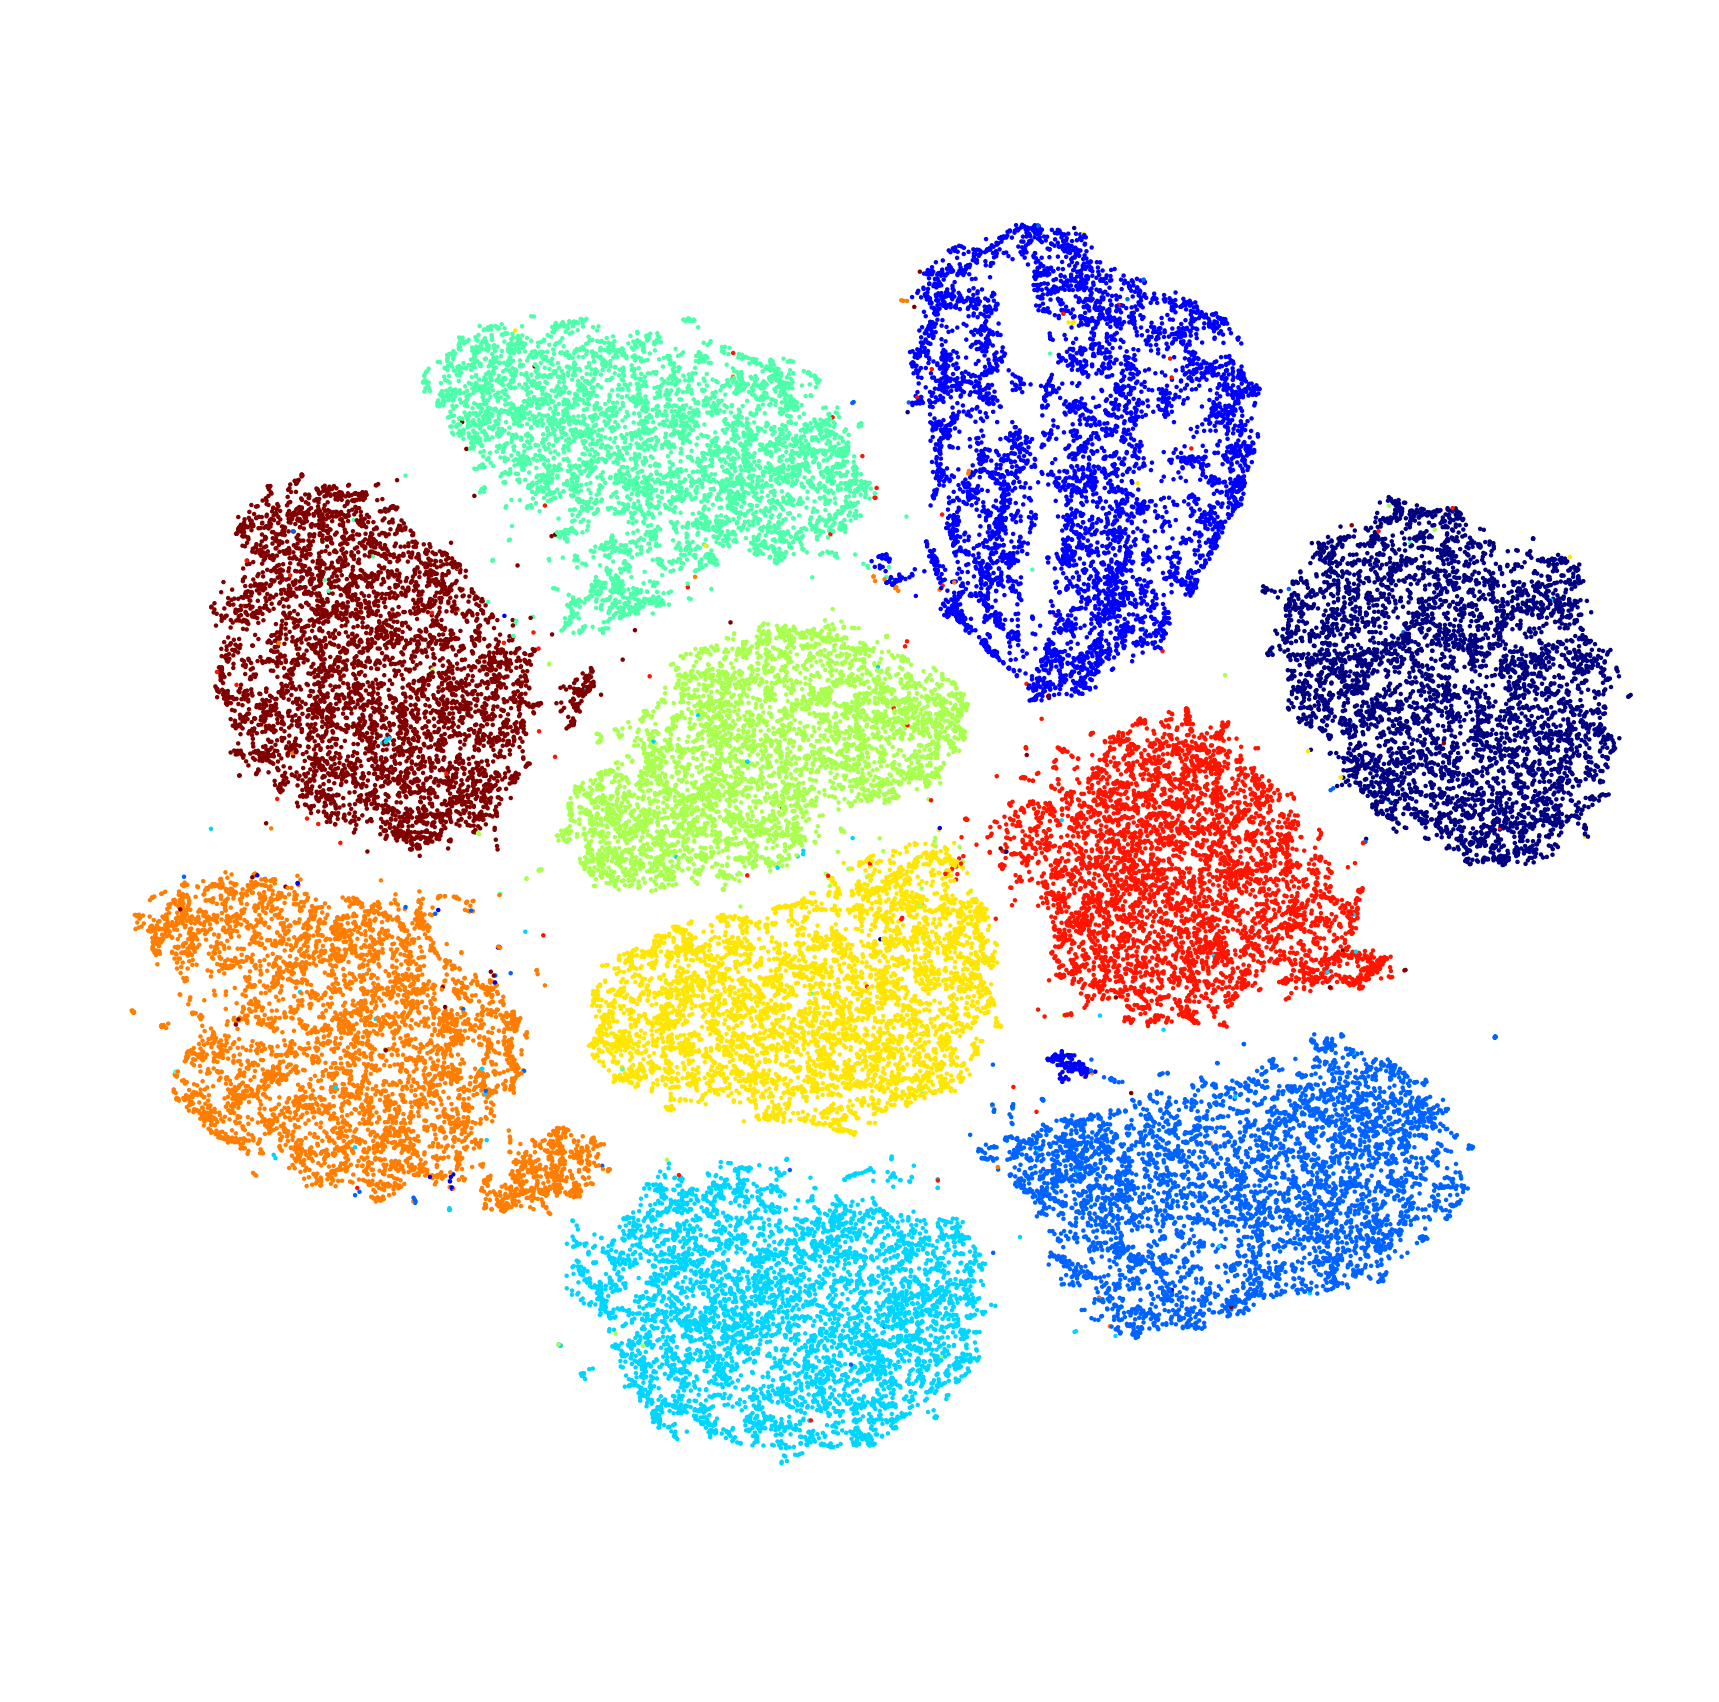

In [62]:
# plot the result
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(30, 30, forward=True)
plt.scatter(vis_x, vis_y, c=label[0:len(X2)+1], cmap=plt.cm.get_cmap("jet", 10),  edgecolor = 'none')
plt.axis('off')
plt.show()

Next, let's embed the acutal images onto each projection coordinate to see if we can notice anything neat about the structure of the data.

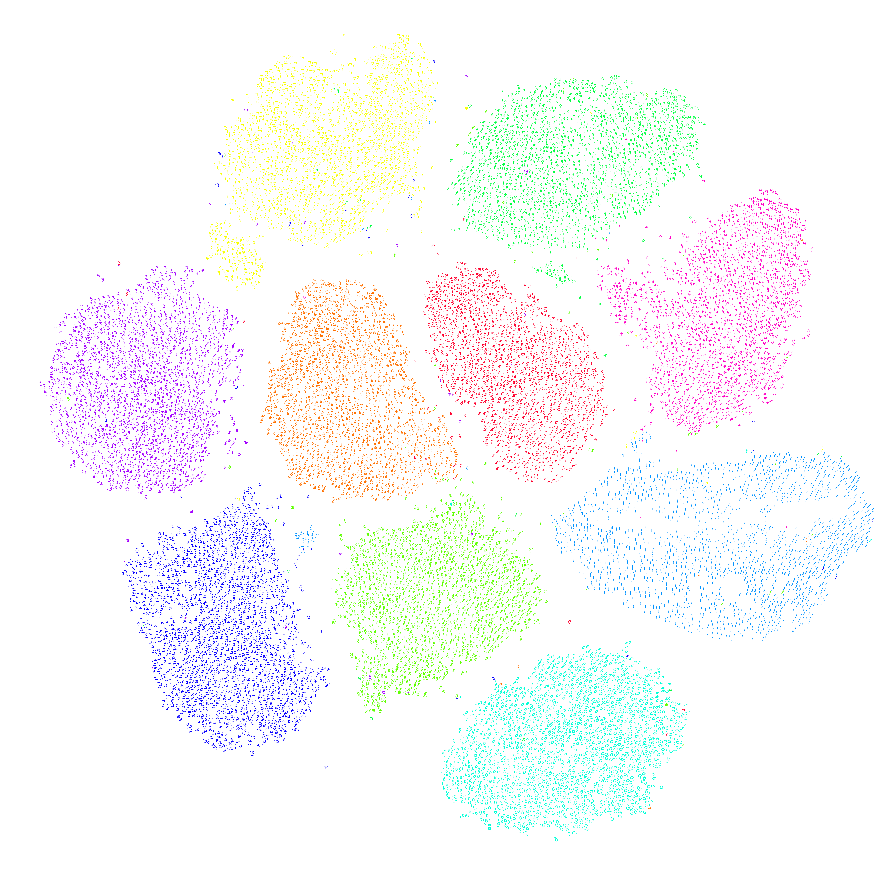

In [63]:
# setup a colormap
colormap = cm.gist_rainbow(np.linspace(0, 255, num_labels).astype(int))

# rescale embedding coordinates within [0, 1]
vis_cnn -= np.min(vis_cnn)
vis_cnn /= np.max(vis_cnn)

# create canvas to embed images
canvas_size = 5000
canvas = np.zeros((canvas_size, canvas_size, 3)).astype(np.uint8)

# set image_size, will downsample if smaller than 28
image_size = 28
scale = canvas_size-image_size

# embed images onto canvas
num_samples = len(vis_cnn)
for i in range(num_samples):
    pos = np.ceil(vis_cnn[i,:]*scale).astype(int)
    downsample_img =imresize(np.reshape(X_train[index[i]], (28,28)),(image_size, image_size))
    for j in range(3):
        canvas[pos[0]:pos[0]+image_size,pos[1]:pos[1]+image_size,j] = downsample_img*colormap[label[i]][j]
            
    
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(15, 15, forward=True)
plt.imshow(np.invert(canvas), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

Another interesting thing to try is to see what tSNE learns after each layer. But some of the layers have too many parameters, so tSNE will take too long for this notebook.

## Convolutional autoencoder visualization
Next, let's try a convolutional autoencoder. 

In [141]:
# build model
input_var = T.tensor4('input')

l_in = layers.InputLayer(shape=(None,1,28,28), input_var=input_var, name='input')

l_conv1 = layers.Conv2DLayer(l_in, num_filters=15, filter_size=(5,5), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='same')
l_bias1 = layers.BiasLayer(l_conv1, b=init.Constant(0.05))
l_nonlin1 = layers.NonlinearityLayer(l_bias1, nonlinearity=nonlinearities.rectify)
l_pool1 = layers.MaxPool2DLayer(l_nonlin1, pool_size=(2,2))

l_conv3 = layers.Conv2DLayer(l_pool1, num_filters=30, filter_size=(5,5), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='same')
l_bias3 = layers.BiasLayer(l_conv3, b=init.Constant(0.05))
l_nonlin3 = layers.NonlinearityLayer(l_bias3, nonlinearity=nonlinearities.rectify)
l_pool3 = layers.MaxPool2DLayer(l_nonlin3, pool_size=(2,2))

l_dense4 = layers.DenseLayer(l_pool3,  num_units=200, W=init.GlorotUniform(), 
                             nonlinearity=None, b=None)
l_bias4 = layers.BiasLayer(l_dense4, b=init.Constant(0.0))
l_nonlin4 = layers.NonlinearityLayer(l_bias4, nonlinearity=nonlinearities.rectify)
                                     
l_dense5 = layers.DenseLayer(l_nonlin4,  num_units=30, W=init.GlorotUniform(), 
                             nonlinearity=None, b=None)
l_bias5 = layers.BiasLayer(l_dense5, b=init.Constant(0.0))
l_nonlin5 = layers.NonlinearityLayer(l_bias5, nonlinearity=nonlinearities.sigmoid)

l_enc = layers.NonlinearityLayer(l_nonlin5, nonlinearity=None)

l_dec9 = layers.InverseLayer(l_enc, l_dense5)
l_bias9 = layers.BiasLayer(l_dec9, init.Constant(0.0))
l_nonlin9 = layers.NonlinearityLayer(l_bias9, nonlinearity=nonlinearities.sigmoid)

l_dec8 = layers.InverseLayer(l_nonlin9, l_dense4)
l_bias8 = layers.BiasLayer(l_dec8, init.Constant(0.0))
l_nonlin8 = layers.NonlinearityLayer(l_bias8, nonlinearity=nonlinearities.rectify)

l_depool6 = layers.InverseLayer(l_nonlin8, l_pool3)
l_dec6 = layers.InverseLayer(l_depool6, l_conv3)
l_bias6 = layers.BiasLayer(l_dec6, init.Constant(0.05))
l_nonlin6 = layers.NonlinearityLayer(l_bias6, nonlinearity=nonlinearities.rectify)

l_depool7 = layers.InverseLayer(l_nonlin6, l_pool1)
l_deconv7 = layers.InverseLayer(l_depool7, l_conv1)
l_bias7 = layers.BiasLayer(l_deconv7, init.Constant(0.05))
l_out = layers.NonlinearityLayer(l_bias7, nonlinearity=nonlinearities.rectify)

# train and validation loss
prediction = get_output(l_out)
train_loss = objectives.squared_error(prediction, input_var)
train_loss = train_loss.mean()

valid_prediction = get_output(l_out, deterministic=True)
valid_loss = objectives.squared_error(valid_prediction, input_var)
valid_loss = valid_loss.mean()

# optimizer
params = get_all_params(l_out, trainable=True)
update_op = updates.adam(train_loss, params)

# theano function
train_function = theano.function([input_var], train_loss, updates=update_op)
valid_function = theano.function([input_var], valid_loss)

#### train model

In [143]:
batch_size = 512
num_train_batches = len(X_train) // batch_size
train_batches = batch_generator(X_train, y_train, batch_size)

num_valid_batches = len(X_valid) // batch_size
valid_batches = batch_generator(X_valid, y_valid, batch_size)

# train network (for short time -- MNIST is quick to train)
n_epochs = 10
for e in range(n_epochs):
    ave_loss = 0
    for index in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        train_loss = train_function(X_batch)
        ave_loss += train_loss
    print("train: %f" % float(ave_loss/num_train_batches))

    ave_loss = 0
    for index in range(num_valid_batches):
        X_batch, y_batch = next(valid_batches)
        valid_loss = valid_function(X_batch)
        ave_loss += valid_loss
    print("valid: %f" % float(ave_loss/num_valid_batches))
    

train: 0.003774
valid: 0.003606
train: 0.003845
valid: 0.003680
train: 0.004070
valid: 0.004017
train: 0.004045
valid: 0.004031
train: 0.003934
valid: 0.003708
train: 0.004163
valid: 0.003760
train: 0.003946
valid: 0.003992
train: 0.003861
valid: 0.003881
train: 0.003742
valid: 0.003616
train: 0.003938
valid: 0.003969


Let's plot the original images and the reconstructed images to see how well we did.

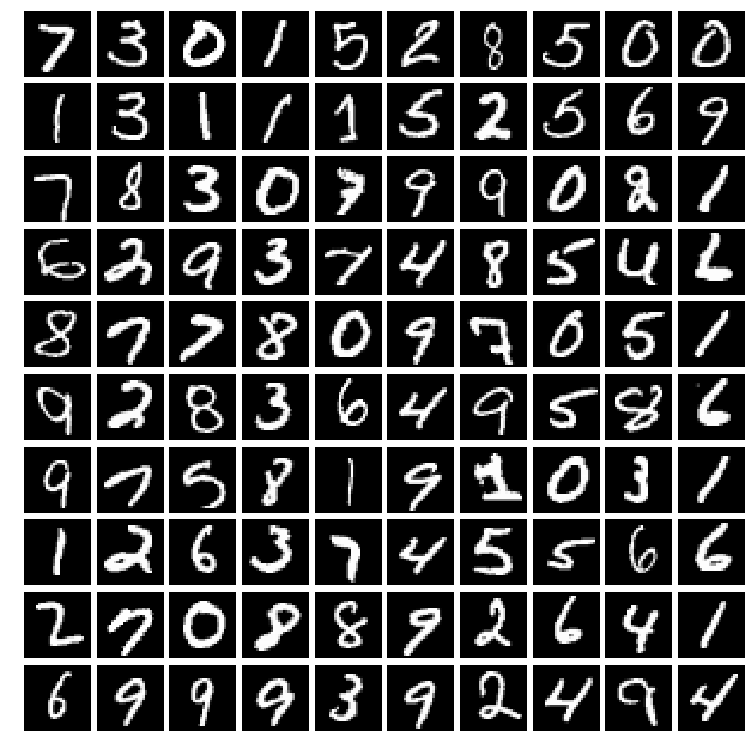

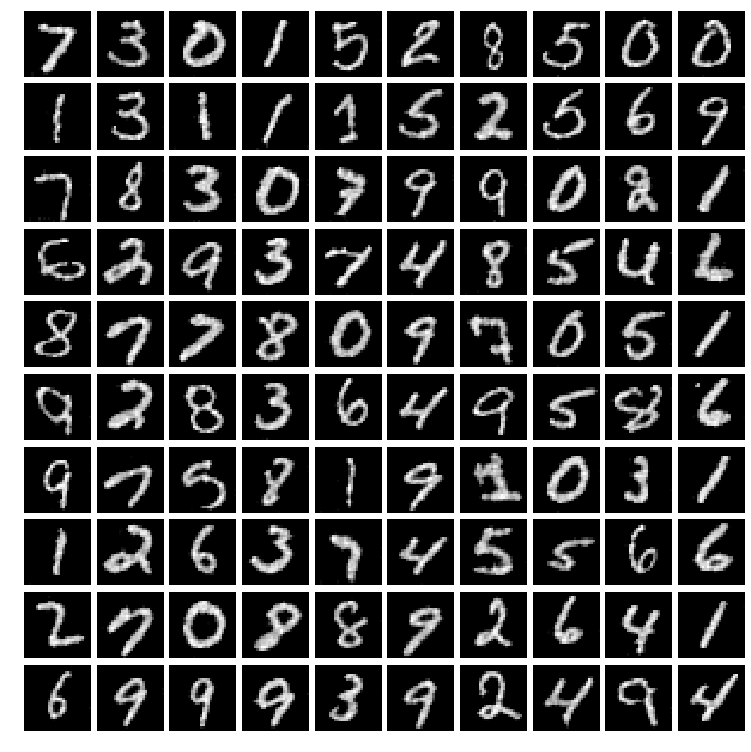

In [144]:
full = theano.function([input_var], layers.get_output(l_out), allow_input_downcast=True)
encode = theano.function([input_var], layers.get_output(l_enc), allow_input_downcast=True)

target_var = T.dmatrix('codes')
out_expr = layers.get_output(l_out, {l_enc:target_var})
fn = theano.function([target_var, l_in.input_var], out_expr, allow_input_downcast=True)

width = 10
height = 10
offset = 4000

index = range(offset, offset+width*height)

plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    orig_image = np.expand_dims(X_train[index[i]], axis=0) 
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(orig_image), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()


plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    orig_image = np.expand_dims(X_train[index[i]], axis=0) 
    code = encode(orig_image)
    encode_image = fn(code, orig_image)
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(encode_image), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()


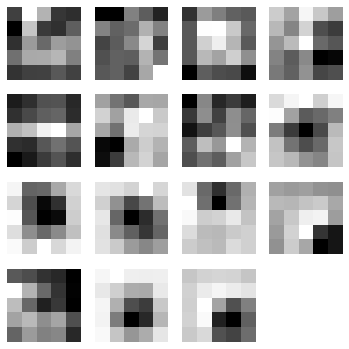

In [145]:
def plot_conv_weights(layer, figsize=(6, 6)):
    """nolearn's plot the weights of a specific layer"""

    W =  np.squeeze(layer.W.get_value())
    shape = W.shape
    nrows = np.ceil(np.sqrt(shape[0])).astype(int)
    ncols = nrows

    figs, axes = plt.subplots(nrows, ncols, figsize=figsize,frameon=False)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    for i, ax in enumerate(axes.ravel()):
        if i >= shape[0]:
            break
        im = ax.imshow(W[i], cmap='gray', interpolation='nearest')

    return figs, axes


figs, axes = plot_conv_weights(l_conv1)


In [146]:
shape = get_output_shape(l_pool3)
encode = theano.function([input_var], layers.get_output(l_pool3), allow_input_downcast=True)

batch_size = 512
num_batches = len(X_train) // batch_size
val = np.zeros(shape[1]*shape[2]*shape[3])
label = np.zeros(1)
index = np.zeros(1)
for i in range(num_batches):
    index = np.vstack([index, np.reshape(np.arange(i*batch_size,(i+1)*batch_size), (batch_size,-1) )])
    code = encode(X_train[i*batch_size:(i+1)*batch_size])
    val = np.vstack([val, np.reshape(code, (batch_size,-1))])
    label = np.vstack([label, np.reshape(y_train[i*batch_size:(i+1)*batch_size], (batch_size,-1))])
val.shape
label = np.squeeze(label)
index = np.squeeze(index)
X2 = np.reshape(val, (val.shape[0],-1))


vis_cae = bh_sne(X2.astype(float))
vis_x = vis_cae[:, 0]
vis_y = vis_cae[:, 1]

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


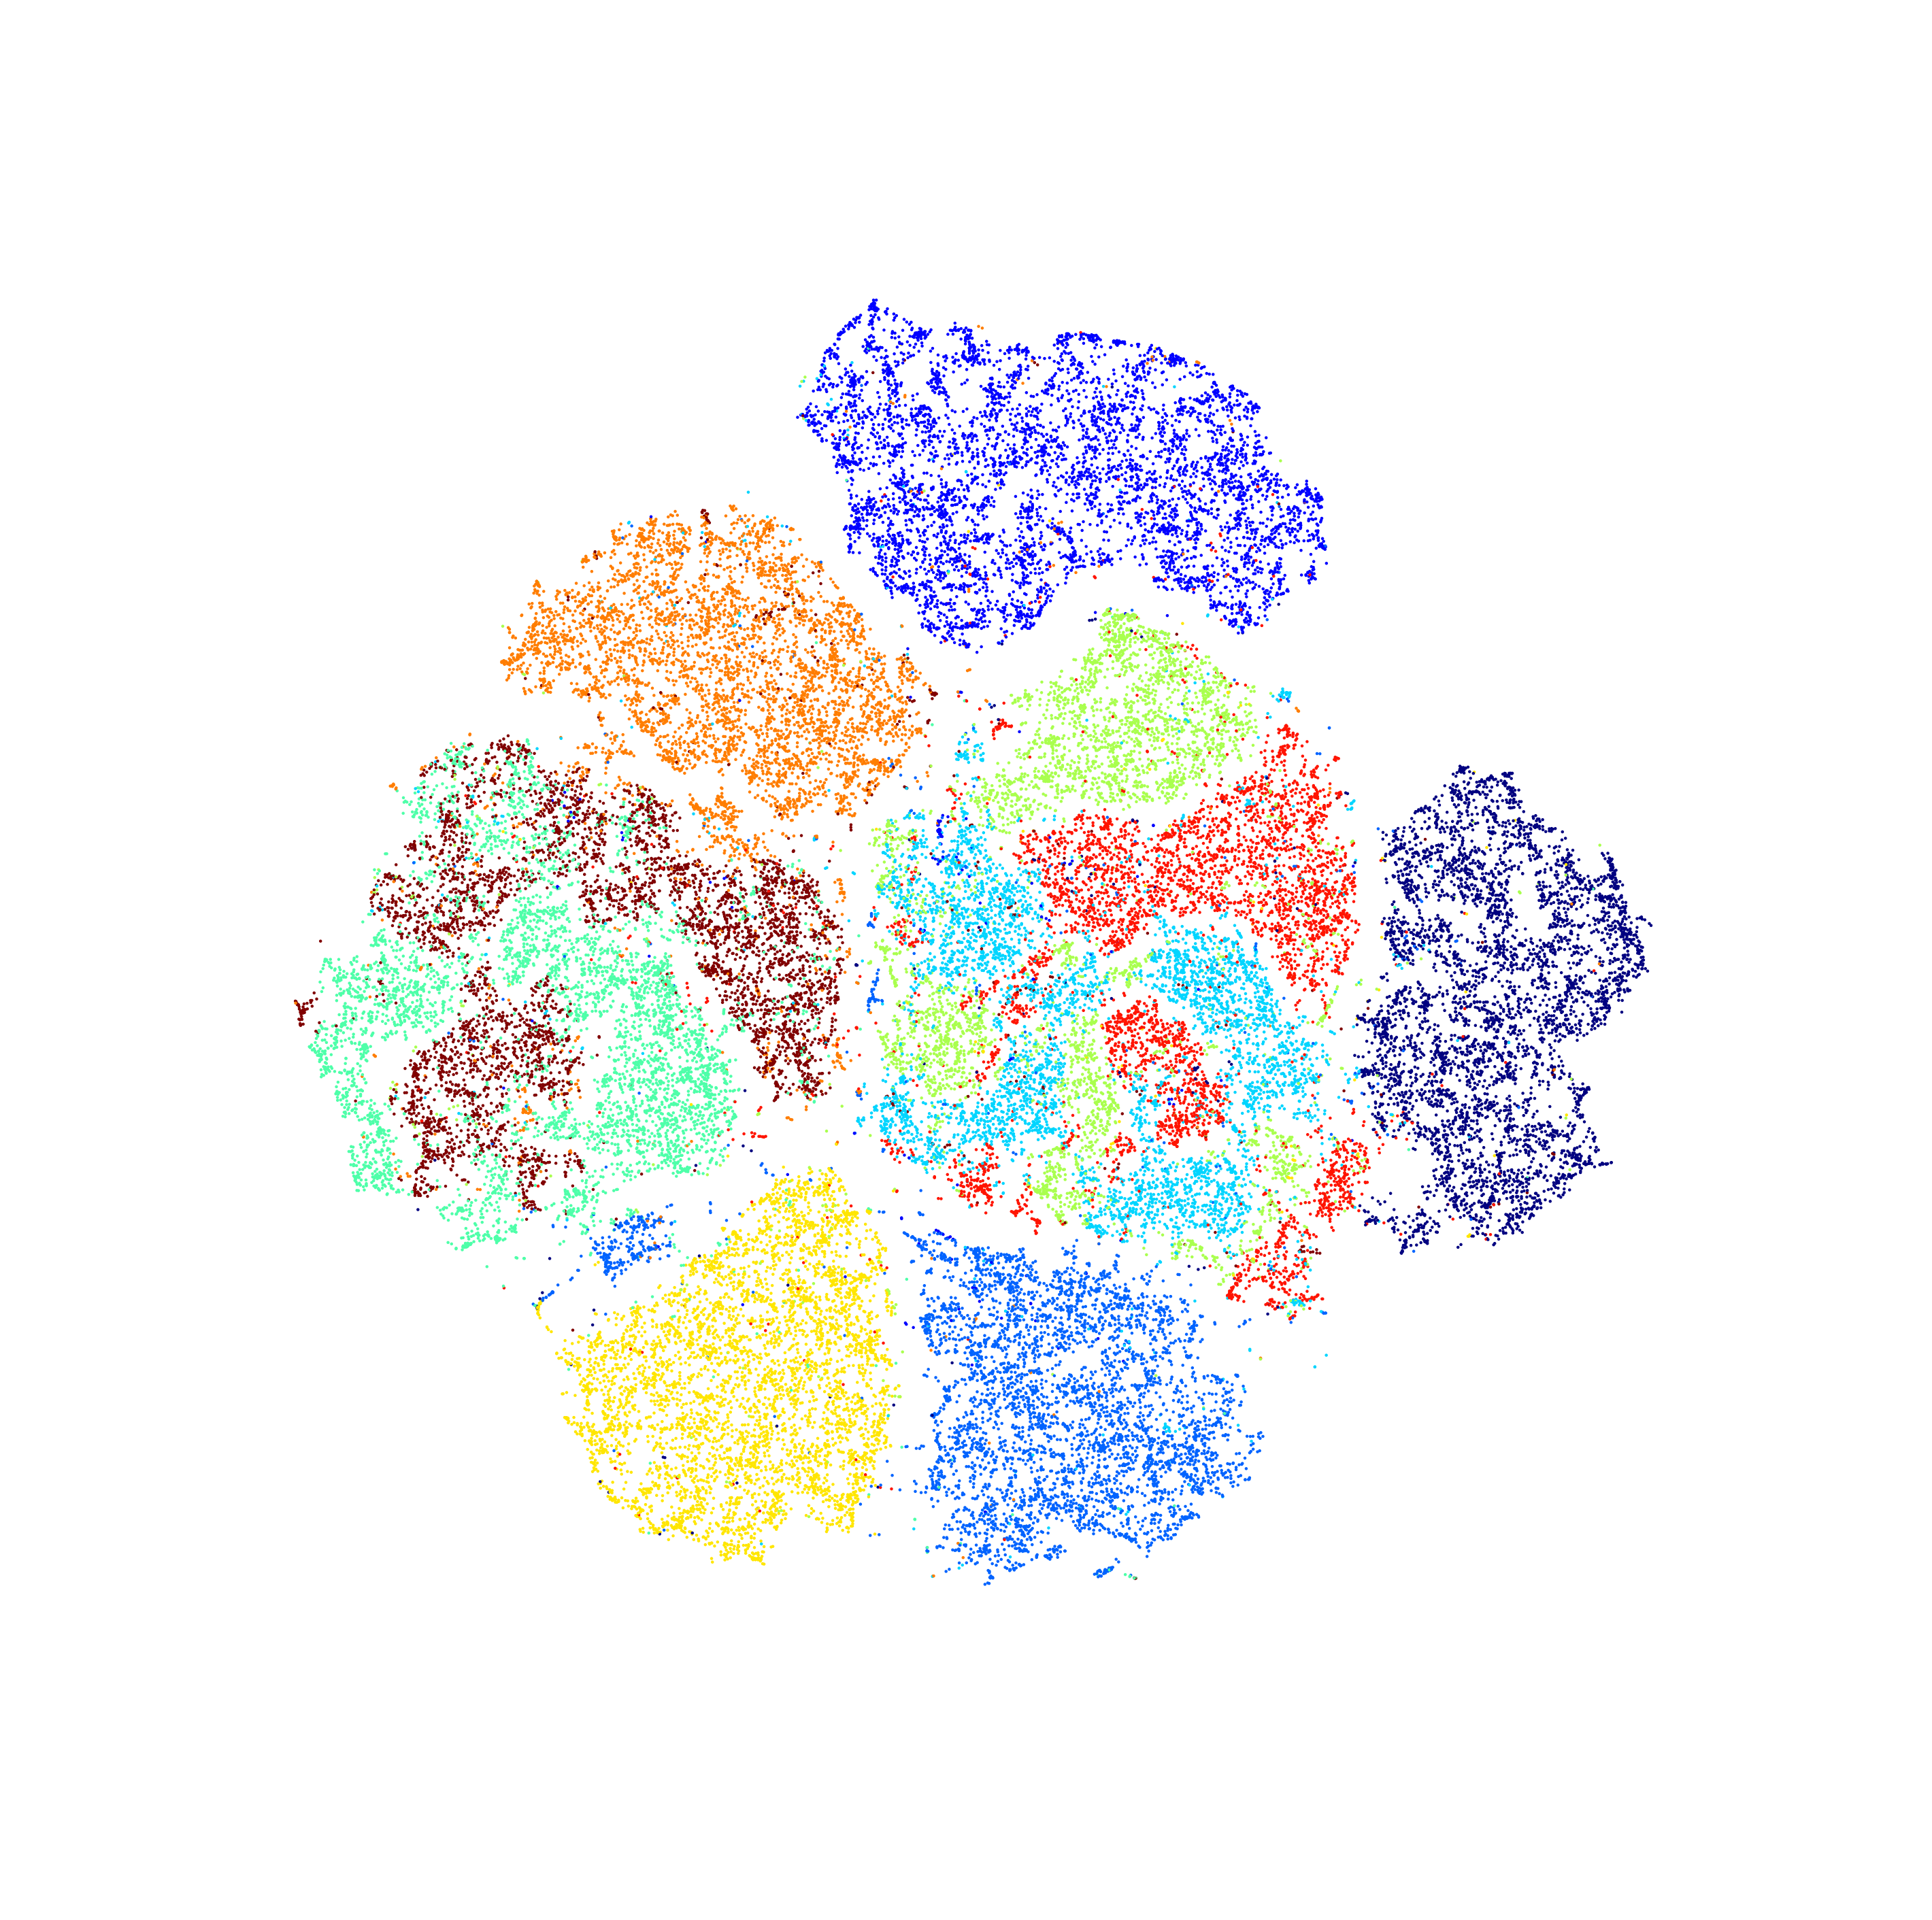

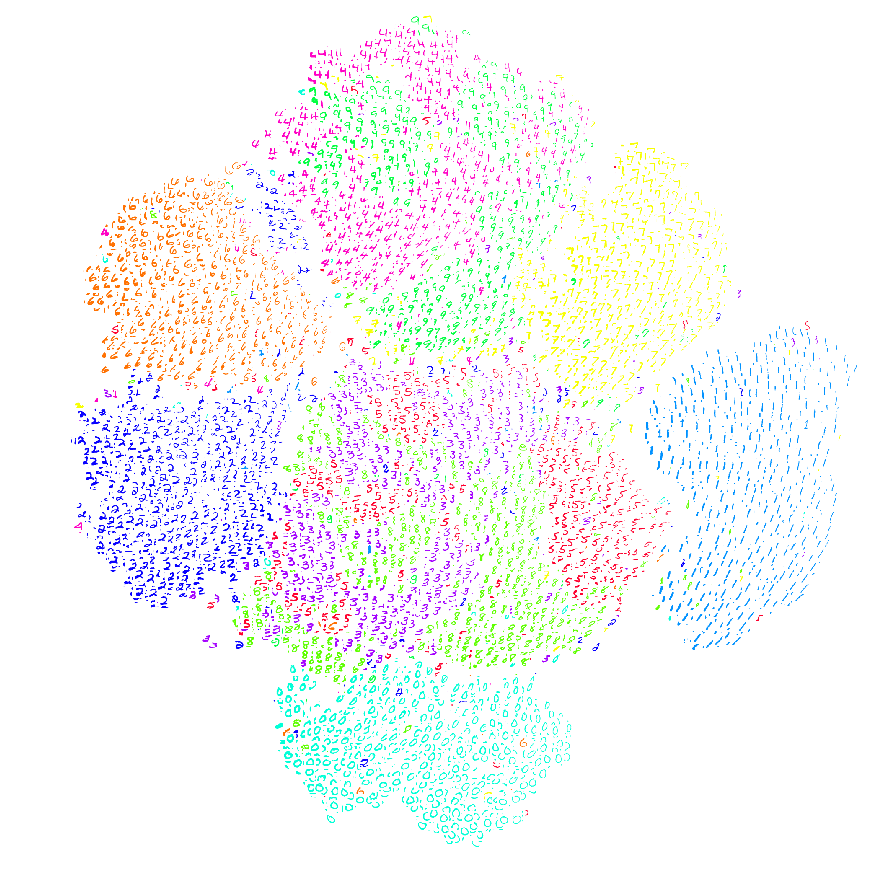

In [148]:
# plot the result
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y, c=label[0:len(X2)+1], cmap=plt.cm.get_cmap("jet", 10),  edgecolor = 'none')
plt.axis('off')

# setup a colormap
colormap = cm.gist_rainbow(np.linspace(0, 255, num_labels).astype(int))

# rescale embedding coordinates within [0, 1]
vis_cae -= np.min(vis_cae)
vis_cae /= np.max(vis_cae)

# create canvas to embed images
canvas_size = 2000
canvas = np.zeros((canvas_size, canvas_size, 3)).astype(np.uint8)

# set image_size, will downsample if smaller than 28
image_size = 28
scale = canvas_size-image_size

# embed images onto canvas
num_samples = len(vis_cae)
for i in range(num_samples):
    pos = np.ceil(vis_cae[i,:]*scale).astype(int)
    downsample_img =imresize(np.reshape(X_train[index[i]], (28,28)),(image_size, image_size))
    for j in range(3):
        canvas[pos[0]:pos[0]+image_size,pos[1]:pos[1]+image_size,j] = downsample_img*colormap[label[i]][j]
            
    
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(15, 15, forward=True)
plt.imshow(np.invert(canvas), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()